### Dpi Setting

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


# Dependencies

### Python

In [4]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [5]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from rpy2.robjects.packages import importr


In [7]:
%load_ext rpy2.ipython

### R

In [8]:
%%R

if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Loading required package: Matrix
Loading required package: sampling
Loading required package: BalancedSampling
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


### Imports

In [9]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

/home/divar/projects/geometric-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

### Scores in R

In [10]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[1][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

# Handpicked Cases

## Linear 1D

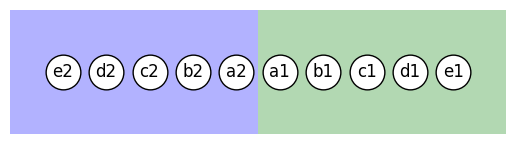

   Sample   # Density Voronai  Moran Local Balance
0   ai aj   1    0.14     0.0  -0.25          0.49
1   ai bi   2    0.14    0.04  -0.06          0.55
2   ai bj   2    0.11    0.04  -0.17          0.39
3   ai ci   2    0.11    0.04    0.0          0.52
4   ai cj   2    0.07    0.04  -0.79          0.36
5   ai di   2    0.07    0.16  -0.24          0.59
6   ai dj   2    0.02    0.16  -0.84          0.47
7   ai ei   2    0.02    0.25   -0.2          0.71
8   ai ej   2     0.0    0.16   -1.0          0.58
9   bi bj   1    0.07     0.0  -0.79          0.25
10  bi ci   2    0.14    0.16   0.06          0.69
11  bi cj   2    0.02    0.01  -0.84          0.18
12  bi di   2    0.11    0.36   0.13          0.76
13  bi dj   2     0.0    0.04   -1.0          0.28
14  bi ei   2    0.07    0.36  -0.13          0.85
15  bi ej   2    0.03    0.04  -0.76          0.42
16  ci cj   1     0.0     0.0   -1.0           0.0
17  ci di   2    0.14    0.36   0.19          0.89
18  ci dj   2    0.03    0.01  

In [11]:
points = {
    (0.35,): "a1",
    (-0.35,): "a2",
    (1.05,): "b1",
    (-1.05,): "b2",
    (1.75,): "c1",
    (-1.75,): "c2",
    (2.45,): "d1",
    (-2.45,): "d2",
    (3.15,): "e1",
    (-3.15,): "e2",
}

N = len(points)
n = 2
split_size = 0.01
coords = np.array(list(points.keys()))
probs = rng.equal_probabilities(n, N)
fig, ax = plt.subplots()
for (x,), label in points.items():
    ax.plot(x, 0, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, 0, label, color="black", ha="center", va="center", fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
ax.axis("off")
ax.axvspan(0, 4, facecolor='green', alpha=0.3)
ax.axvspan(-4, 0, facecolor='blue', alpha=0.3)

plt.show()

dic_score = {}
for i, j in combinations(range(0, N), 2):
    i_label, j_label = points[tuple(coords[i])], points[tuple(coords[j])]
    if i_label[1] == j_label[1]:
        identifier = f"{i_label[0]}i {j_label[0]}i"
    else:
        identifier = f"{i_label[0]}i {j_label[0]}j"
    sample_idx = np.array([i, j])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx, split_size,)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 2)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.round(np.mean(all_scores, axis=0), 2)


result.append(
    np.concatenate([["Mean", len(all_scores)], overall_mean])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
# print(df.to_latex(index=False))
print(df)

## 4 3x3

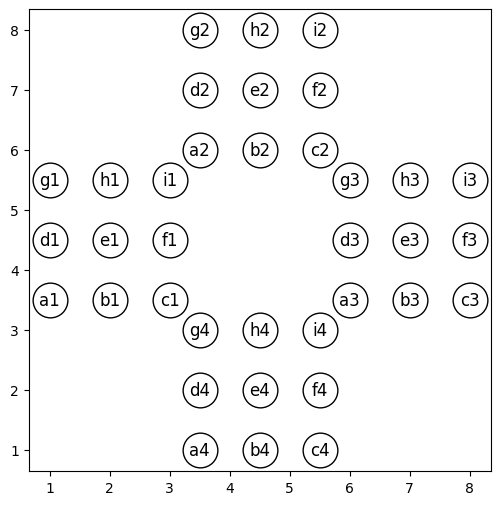

,Sample,Density,Voronai,Moran,Local Balance
0,e1 e2 e3 e4,0.00,0.00,-1.00,0.00
1,a1 a2 a3 a4,0.00,0.11,-0.59,0.43
2,d1 d2 d3 d4,0.00,0.02,-0.83,0.28
3,b1 d2 h3 f4,0.02,0.00,-0.75,0.19
4,f1 b2 d3 h4,0.33,0.00,-0.69,0.26
5,d1 h2 f3 b4,0.40,0.00,-0.50,0.26
6,a1 c1 g1 i1,0.34,0.56,0.38,0.84
7,b1 d1 f1 h1,0.48,0.56,0.52,0.79
8,h1 d2 b3 f4,0.03,0.00,-0.00,0.26


\begin{tabular}{llllll}
\toprule
 & Sample & Density & Voronai & Moran & Local Balance \\
\midrule
0 & e1 e2 e3 e4 & 0.00 & 0.00 & -1.00 & 0.00 \\
1 & a1 a2 a3 a4 & 0.00 & 0.11 & -0.59 & 0.43 \\
2 & d1 d2 d3 d4 & 0.00 & 0.02 & -0.83 & 0.28 \\
3 & b1 d2 h3 f4 & 0.02 & 0.00 & -0.75 & 0.19 \\
4 & f1 b2 d3 h4 & 0.33 & 0.00 & -0.69 & 0.26 \\
5 & d1 h2 f3 b4 & 0.40 & 0.00 & -0.50 & 0.26 \\
6 & a1 c1 g1 i1 & 0.34 & 0.56 & 0.38 & 0.84 \\
7 & b1 d1 f1 h1 & 0.48 & 0.56 & 0.52 & 0.79 \\
8 & h1 d2 b3 f4 & 0.03 & 0.00 & -0.00 & 0.26 \\
\bottomrule
\end{tabular}



In [12]:
samples = np.array([
    ["e1", "e2", "e3", "e4"],
    ["a1", "a2", "a3", "a4"],
    ["d1", "d2", "d3", "d4"],
    ["f4", "h3", "d2", "b1"],
    ["f1", "b2", "d3", "h4"],
    ["f3", "d1", "b4", "h2"],
    ["a1", "c1", "g1", "i1"],
    ["b1", "d1", "f1", "h1"],
    #### NEW Interstings
    "h1 d2 b3 f4".split(" "),
])

x3coords = rng.grid_coordinates((3, 2)) * 2
x3probs = rng.equal_probabilities(1, 9)

left = x3coords.copy()
right = x3coords.copy()
up = x3coords.copy()
down = x3coords.copy()

left_labels = [chr(ord('a') + i) + '1' for i in range(9)]
right_labels = [chr(ord('a') + i) + '3' for i in range(9)]
up_labels = [chr(ord('a') + i) + '2' for i in range(9)]
down_labels = [chr(ord('a') + i) + '4' for i in range(9)]

####### TEST
import itertools
# samples = np.array([
#     [l, u, r, d]
#     for l, u, r, d in itertools.product(left_labels, up_labels, right_labels, down_labels)
# ])
#######

left[:, 0] += 1
left[:, 1] += 3.5
right[:, 0] += 6
right[:, 1] += 3.5
up[:, 0] += 3.5
up[:, 1] += 6
down[:, 0] += 3.5
down[:, 1] += 1


coords = np.vstack([left, right, up, down])
probs = np.concatenate([x3probs, x3probs, x3probs, x3probs])
labels = np.concatenate([left_labels, right_labels, up_labels, down_labels])
label_to_idx = {l: idx for idx, (c, l) in enumerate(zip(coords, labels))}
assert len(probs) == len(coords) == len(labels)

N = len(coords)
n = 4
split_size = .01
points = {}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
for (x, y), label in zip(coords, labels):
    points[label] = (x, y)
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', label=1, markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

plt.show()

results = []
for sample in samples:
    sample_idx = np.array([label_to_idx[s] for s in sample])
    identifier = " ".join(sorted(sample, key=lambda x: x[1]))
    s = scores(coords, probs, n, N, sample_idx, split_size,)
    s_formatted = [f"{num:.2f}" for num in s]  # Corrected line
    results.append([identifier] + s_formatted)

df = pd.DataFrame(results, columns=["Sample", "Density", "Voronai", "Moran", "Local Balance"])
display(df)
print(df.to_latex())


## Rotating

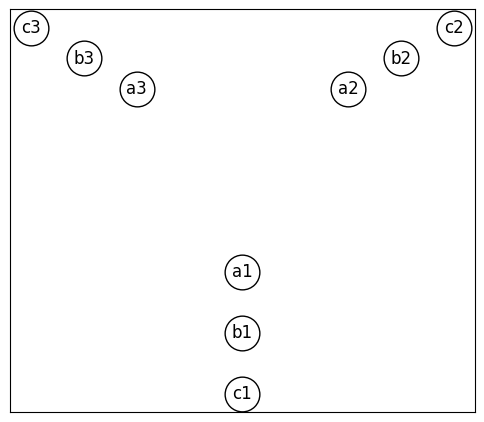

,Sample,#,Density,Voronai,Moran,Local Balance
0,aaa,1,0.56,0.0,-1.0,0.263
1,aab,3,0.3,0.0,-1.0,0.214
2,aac,3,0.141,0.0,-1.0,0.263
3,abb,3,0.101,0.0,-1.0,0.152
4,abc,6,0.045,0.0,-1.0,0.214
5,acc,3,0.039,0.0,-1.0,0.263
6,bbb,1,0.0,0.0,-1.0,0.0
7,bbc,3,0.067,0.0,-1.0,0.152
8,bcc,3,0.161,0.0,-1.0,0.214
9,ccc,1,0.223,0.0,-1.0,0.263


In [13]:
def rotate_point(p, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.array([
        p[0] * cost - p[1] * sint,
        p[0] * sint + p[1] * cost
    ])

def rotate_matrix(matrix, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.apply_along_axis(rotate_point, 1, matrix, t, cost, sint)

template = np.array([
    [0.0, -0.5],
    [0.0, -1],
    [0.0, -1.5]
])
template = np.array([
    [0.0, -2],
    [0.0, -3],
    [0.0, -4]
])

angles = np.arange(0, 3) * (2.0 * np.pi / 3.0)
pop = np.vstack([rotate_matrix(template, angle) for angle in angles])

all_points = pop
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "a3", "b3", "c3"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

for (x, y), label in zip(all_points, labels):
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

N = len(all_points)
n = 3
split_size=0.01
coords = np.array(all_points)
probs = rng.equal_probabilities(n, N)

from itertools import combinations, combinations_with_replacement

dic_score = {}
for i, j, k in combinations(range(0, N), 3):
    i_label, j_label, k_label = labels[i], labels[j], labels[k]
    ids = list(sorted([i_label[0], j_label[0], k_label[0]]))
    identifier = "".join(ids)

    if len(set([i_label[1], j_label[1], k_label[1]])) != n:
      continue

    sample_idx = np.array([i, j, k])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx, split_size)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 3)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.mean(all_scores, axis=0)


result.append(
    np.concatenate([["Mean", len(all_scores)], np.round(overall_mean, 2)])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])

display(df)
# print(df.to_latex())

# Simulations

## Methods

In [14]:
def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    return gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=n_zones, tolerance=2, split_size=0.001).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
        mask <- UPmaxentropy(probs)
        """
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

    return np.array(samples)


def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx


def find_samples(coords, probs, n, num_samples):
    return {
        "K-Means (1, 1)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        "K-Means (3, 3)": k_means_samples(coords, probs, n, num_samples, (3, 3)),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
    }

## Initial Population

In [15]:
n = 4 # Number of item in each sample (number of clusters)
sample_cnt = 20 # How many sample gather from each desiging method

### Coords

Uncomment each one you would like to get result from

In [16]:
swiss_plot = 0
######### GRID
grid_size = 20
N = grid_size**2
coords = rng.grid_coordinates((grid_size, 2))


######### RANDOM
# N = 400
# coords = rng.random_coordinates((N, 2))
# idx = np.lexsort((coords[:,1], coords[:,0]))
# coords = coords[idx]

######### CLUSTRED
# n_clusters = 4
# cluster_std = 0.05
# # N = 400
# coords = rng.cluster_coordinates(n_clusters, cluster_std, (N, 2))


######### SWISS: https://docs.google.com/spreadsheets/d/10uYLsZpxRV5lUrsGfy3gI0RD4fAn8lIP/edit?usp=sharing&ouid=117333816980669142577&rtpof=true&sd=true
# swiss_plot = 1
# swiss_df = pd.read_csv('/home/divar/projects/geometric-sampling/swiss.csv')
# coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
# swiss_df['AREA'] = swiss_df['AREA'].clip(lower=1, upper=150)
# N = len(coords)




idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]


### Probabilities

Uncomment each one you would like to get result from

In [17]:
######### EQUAL
probs = rng.equal_probabilities(n, N)


######### UNEQUAL
# probs = np.sort(rng.unequal_probabilities(n, N))
# probs = np.sort(rng.unequal_probabilities(n, N))[::-1]                                                          
if swiss_plot == 1:
    swiss_area = swiss_df['AREA'].to_numpy()
    swiss_area_cliped = swiss_area.clip(1, 150)
    probs = inclusion_probabilities(swiss_area_cliped, n)


## Results

### Plotting coords

In [18]:
method_hard = gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
pop_hard = method_hard.popu

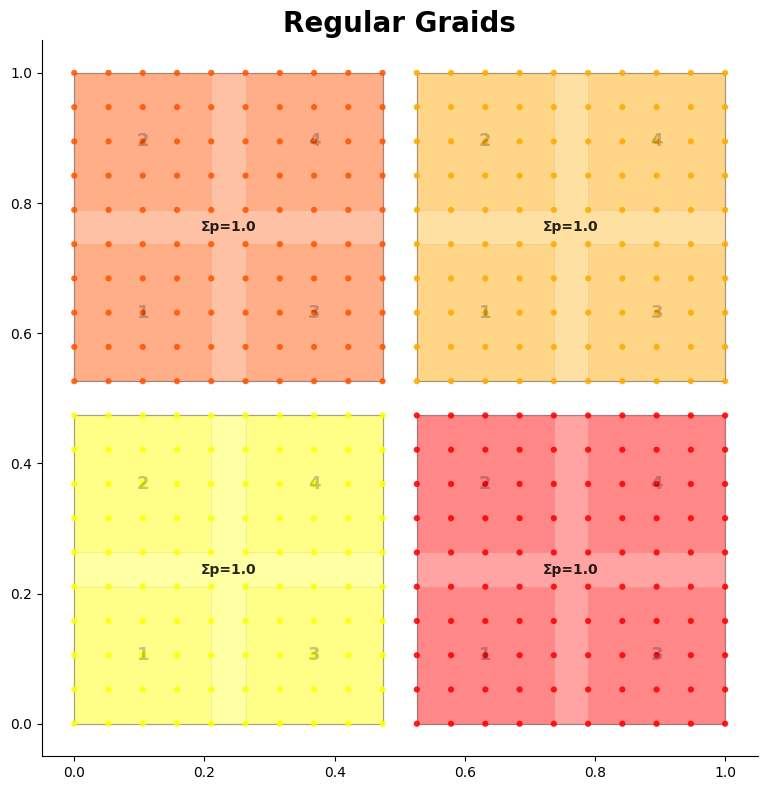

In [19]:
pop_hard.plot(figsize=(8, 8))
ax = plt.gca()
ax.set_title("Regular Graids", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [20]:
import geopandas as gpd
shp_path = "/home/divar/Downloads/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(shp_path)

In [21]:
swiss = world[world['ADMIN'] == 'Switzerland']
print(swiss.crs)
swiss = swiss.to_crs(epsg=2056)  # For LV95

EPSG:4326


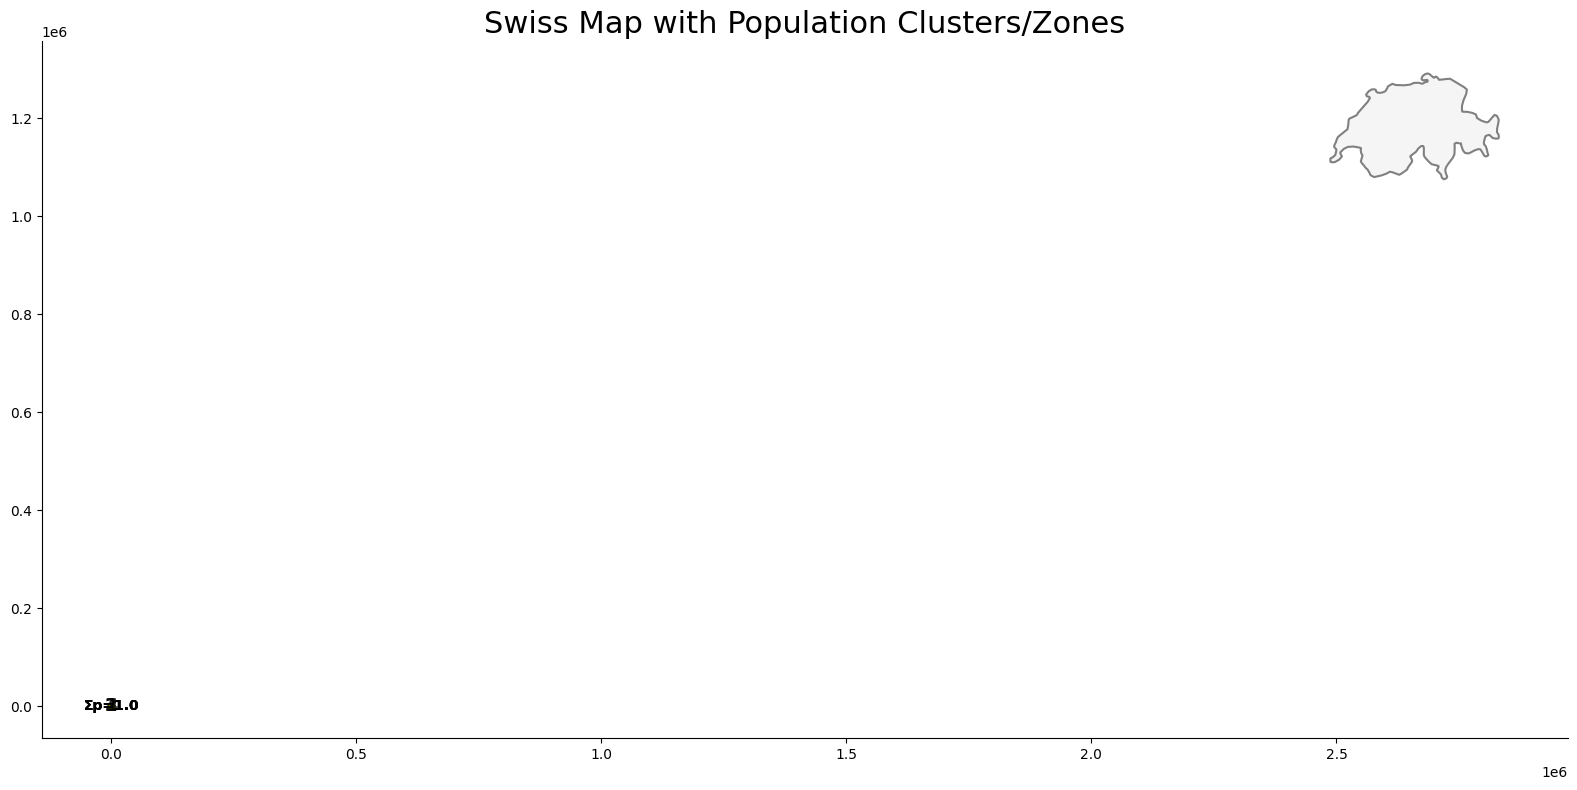

In [22]:
fig, ax = plt.subplots(figsize=(20, 8))
swiss.plot(ax=ax, color="whitesmoke", edgecolor="gray", linewidth=1.5, zorder=0)
pop_hard.plot(ax=ax)
ax.set_title("Swiss Map with Population Clusters/Zones", fontsize=22)
plt.tight_layout()
plt.show()

# Plots

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# --- SEEDING for reproducibility ---
np.random.seed(42)

# --- PARAMS ---
n = 8                         # Target sample size
grid_size = 10                  # For grid, grid_size^2 points → 400 total
n_clusters = 8                  # For clustered
cluster_std = 0.1
swiss_csv = '/home/divar/projects/geometric-sampling/swiss.csv'
swiss_shp = '/home/divar/Downloads/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'

# -- You must define/provide these based on your project --
# rng.grid_coordinates(shape), rng.random_coordinates(shape), rng.cluster_coordinates, etc.
# rng.equal_probabilities(n, N), rng.unequal_probabilities(n, N)
# inclusion_probabilities()
# gs.sampling.KMeansSpatialSamplingSimple  # for making pop object with plot()

# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}

# --- 2. REGULAR GRID ---
coords_grid = rng.grid_coordinates((grid_size, 2))
coords_grid = coords_grid[np.lexsort((coords_grid[:, 1], coords_grid[:, 0]))]
N_grid = coords_grid.shape[0]
probs_grid_eq = rng.equal_probabilities(n, N_grid)
probs_grid_uneq = np.sort(rng.unequal_probabilities(n, N_grid))

populations['grid'] = coords_grid
probabilities['grid_eq'] = probs_grid_eq
probabilities['grid_uneq'] = probs_grid_uneq

# --- 3. RANDOM ---
coords_rand = rng.random_coordinates((N_grid, 2))
coords_rand = coords_rand[np.lexsort((coords_rand[:, 1], coords_rand[:, 0]))]
probs_rand_eq = rng.equal_probabilities(n, N_grid)
probs_rand_uneq = np.sort(rng.unequal_probabilities(n, N_grid))

populations['random'] = coords_rand
probabilities['random_eq'] = probs_rand_eq
probabilities['random_uneq'] = probs_rand_uneq

# --- 4. CLUSTERED ---
coords_clust = rng.cluster_coordinates(n_clusters, cluster_std, (N_grid, 2))
coords_clust = coords_clust[np.lexsort((coords_clust[:, 1], coords_clust[:, 0]))]
probs_clust_eq = rng.equal_probabilities(n, N_grid)
probs_clust_uneq = np.sort(rng.unequal_probabilities(n, N_grid))

populations['clust'] = coords_clust
probabilities['clust_eq'] = probs_clust_eq
probabilities['clust_uneq'] = probs_clust_uneq

# --- 5. SWISS ---
swiss_df = pd.read_csv(swiss_csv)
coords_swiss = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
N_swiss = coords_swiss.shape[0]
area = swiss_df['AREA'].clip(1, 150)
probs_swiss_eq = rng.equal_probabilities(n, N_swiss)
probs_swiss_uneq = inclusion_probabilities(area, n)

populations['swiss'] = coords_swiss
probabilities['swiss_eq'] = probs_swiss_eq
probabilities['swiss_uneq'] = probs_swiss_uneq

# ---- 6. Create pop objects (e.g. for your plotting/class methods, using equal probs for now) ----
for key, coords in populations.items():
    if key == 'swiss':
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_eq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
        pop_objs[f'{key}_eq'] = hard.popu
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_uneq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
        pop_objs[f'{key}_uneq'] = hard.popu
    else:
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_eq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
        pop_objs[f'{key}_eq'] = hard.popu
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_uneq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
        pop_objs[f'{key}_uneq'] = hard.popu

# ---- 7. Load Swiss map outline for background ----
world = gpd.read_file(swiss_shp)
swiss_map = world[world['ADMIN'] == 'Switzerland'].to_crs(epsg=2056)



# ==== Populations/coordinat/probs are stored in 'populations' and 'probabilities' dicts for later use ====

In [82]:
import numpy as np
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

autumn_cmap = plt.get_cmap('autumn')
plasma_cmap = plt.get_cmap('plasma')

def get_autumn_colors(n_clusters):
    """Returns n_clusters colors from the autumn colormap."""
    colors = autumn_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

def get_plasma_colors(n_clusters):
    """Returns n_clusters colors from the plasma colormap."""
    colors = plasma_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

# Example usage:
n_clusters = n
import matplotlib.pyplot as plt
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(mc.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

n_clusters = 4
base_colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
light_colors = [lighten_color(col, 0.5) for col in base_colors]

autumn_colors = get_autumn_colors(n_clusters)
plasma_colors = get_plasma_colors(n_clusters)

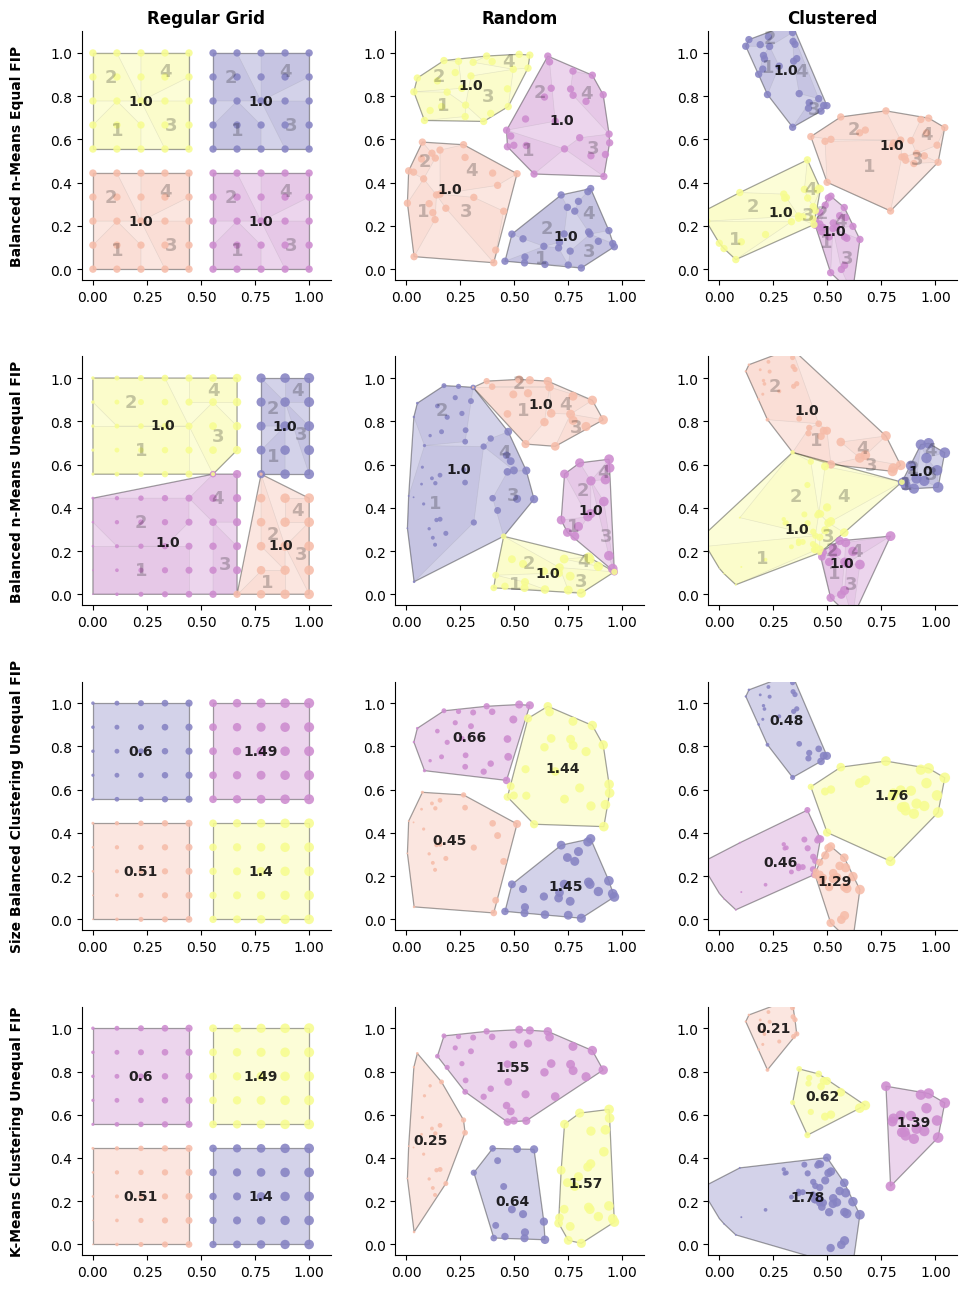

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained

n_clusters = 4  # Change as needed
pop_titles = ['Regular Grid', 'Random', 'Clustered']
row_labels = [
    "Balanced n-Means Equal FIP",
    "Balanced n-Means Unequal FIP",
    "Size Balanced Clustering Unequal FIP",
    "K-Means Clustering Unequal FIP",
    
]
models = ['grid', 'random', 'clust']

def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    if len(points) < 3:
        return None
    hull = ConvexHull(points)
    polygon = Polygon(
        points[hull.vertices],
        closed=True,
        facecolor=color,
        alpha=alpha,
        edgecolor=edge_color,
        lw=line_width,
        zorder=1
    )
    ax.add_patch(polygon)
    return hull

fig, axes = plt.subplots(4, 3, figsize=(10, 13))

for col, model in enumerate(models):
    # ----------- 1st Row: Balanced n-Means Equal FIP -------------
    ax = axes[0, col]
    pops_eq = pop_objs[f'{model}_eq']  # PopulationSimple
    pops_eq.plot(ax=ax)
    ax.set_title(pop_titles[col], fontsize=12, fontweight='bold')

    # ----------- 2nd Row: Balanced n-Means Unequal FIP -----------
    ax = axes[1, col]
    pops_uneq = pop_objs[f'{model}_uneq']  # PopulationSimple
    pops_uneq.plot(ax=ax)
    ax.set_title("")

    # ----------- 3rd Row: KMeans Clustering ----------------------
    ax = axes[3, col]
    X = pops_uneq.coords
    probs = pops_uneq.probs
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(X)
    colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
    colors = light_colors
    p_sum = []
    for clust in range(n_clusters):
        idx = (kmeans.labels_ == clust)
        cluster_points = X[idx]
        cluster_color = colors[clust]
        # Draw convex hull
        if np.sum(idx) >= 3:
            hull = plot_convex_hull(cluster_points, ax,
                                    color=cluster_color, alpha=0.36, edge_color='black', line_width=0.9)
        # Draw points
        ax.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            color=cluster_color,
            edgecolors="none",
            s=probs[idx] * 700,
            alpha=0.88,
            zorder=2,
        )
        prob_sum = round(probs[idx].sum(), 2)
        p_sum.append(prob_sum)
        # Draw cluster sum
        center = cluster_points.mean(axis=0)
        ax.text(center[0], center[1],f"{prob_sum}",# f"Σp={prob_sum}",
                color="black", fontsize=10, weight="bold", alpha=0.85,
                ha="center", va="center", zorder=3)
    ax.set_title("")
    
    # ----------- 4th Row: Size-Balanced KMeans Clustering --------
    ax = axes[2, col]
    kmeans_const = KMeansConstrained(
        n_clusters=n_clusters,
        size_min=int(X.shape[0] / n_clusters),
        size_max=int(np.ceil(X.shape[0] / n_clusters)),
        random_state=1
    ).fit(X)
    p_sum = []
    for clust in range(n_clusters):
        idx = (kmeans_const.labels_ == clust)
        cluster_points = X[idx]
        cluster_color = colors[clust]
        # Draw convex hull
        if np.sum(idx) >= 3:
            hull = plot_convex_hull(cluster_points, ax,
                                    color=cluster_color, alpha=0.36, edge_color='black', line_width=0.9)
        # Draw points
        ax.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            color=cluster_color,
            edgecolors="none",
            s=probs[idx] * 700,
            alpha=0.88,
            zorder=2,
        )
        prob_sum = round(probs[idx].sum(), 2)
        p_sum.append(prob_sum)
        # Draw cluster sum
        center = cluster_points.mean(axis=0)
        ax.text(center[0], center[1], f"{prob_sum}",
                color="black", fontsize=10, weight="bold", alpha=0.85,
                ha="center", va="center", zorder=3)
    ax.set_title("")

# --------- Formatting -----------
# for ax in axes.flatten():
#     ax.set_aspect("equal")
#     for pos in ['top', 'right', 'left', 'bottom']:
#         ax.spines[pos].set_visible(False)
#     ax.set_xticks([]); ax.set_yticks([])
for ax in axes.flatten():
    ax.set_aspect("equal")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-.05, 1.1)
    ax.set_ylim(-.05, 1.1)
    # Keep left and bottom spines visible

# -------- Row Annotations -------
for row in range(4):
    axes[row,0].annotate(row_labels[row],
                         xy=(0, 0.5),
                         xytext=(-axes[row,0].yaxis.labelpad-11, 0),
                         xycoords=axes[row,0].yaxis.label,
                         textcoords='offset points',
                         size=10, ha='right', va='center', fontweight='bold', rotation=90)

plt.tight_layout()
plt.show()

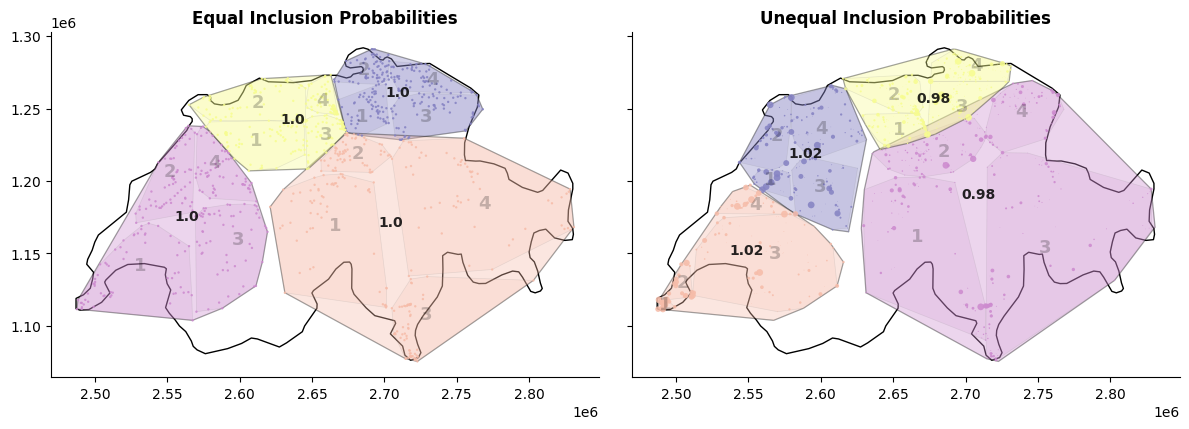

In [103]:
import matplotlib.pyplot as plt

pop_titles = ['Regular Grid', 'Random', 'Clustered', 'Swiss']
col_labels = ["Equal Inclusion Probabilities", "Unequal Inclusion Probabilities"]

for i, model in enumerate(['swiss']):  # Or use more models
    fig, axes = plt.subplots(1, 2, figsize=(12, 12), sharey=True)

    # Equal inclusion (left)
    ax = axes[0]
    if model == 'swiss':
        swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pop_objs[f'{model}_eq'].plot(ax=ax)
    ax.set_title(col_labels[0], fontsize=12, fontweight='bold')
    ax.set_aspect("equal")

    # Unequal inclusion (right)
    ax = axes[1]
    if model == 'swiss':
        swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pop_objs[f'{model}_uneq'].plot(ax=ax)
    ax.set_title(col_labels[1], fontsize=12, fontweight='bold')
    ax.set_ylabel("")
    ax.set_aspect("equal")

    # Only show left and bottom spines (axes)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Left/bottom stays visible for axes labels/ticks

    # Tighten space
    plt.tight_layout(rect=[0, 0.01, 1, 0.93])
    plt.subplots_adjust(wspace=0.06)  # Narrow gap between plots

    # Suptitle close to panels
    #fig.suptitle(pop_titles[i], fontsize=15, fontweight='bold', y=0.94)

    plt.show()

### Gathering Data

In [ ]:
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

sample_methods = find_samples(coords, probs, n, sample_cnt)
scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
rows = np.array([
    [method, *scores(coords, probs, n, N, s, density_measure)]
    for method, samples in sample_methods.items()
    for s in tqdm(samples, total=sample_cnt)
])

df = pd.DataFrame(rows, columns=columns)
df = df.astype({
    "Density": float,
    "Voronoi": float,
    "Moran": float,
    "Local Balance": float
})

ValueError: operands could not be broadcast together with shape (959,) (400,)

# Bardia Simu

In [ ]:
%load_ext autoreload
%autoreload 2
import geometric_sampling as gs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Tables

Means

Describe

In [ ]:
#df.groupby("Method").std()
#df.groupby("Method").mean()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df.groupby("Method").describe())

Density                                                    \
                 count      mean       std       min       25%       50%   
Method                                                                     
K-Means (1, 1)    20.0  0.306916  0.157557  0.029617  0.200442  0.270972   
K-Means (3, 3)    20.0  0.201490  0.082538  0.069953  0.145433  0.192653   
Local Pivotal     20.0  0.205039  0.084755  0.069762  0.146470  0.203701   
Random            20.0  0.197081  0.082437  0.101793  0.128121  0.178632   
UPmaxentropy      20.0  0.268059  0.144837  0.102818  0.139595  0.243320   

                                   Voronoi                                \
                     75%       max   count      mean       std       min   
Method                                                                     
K-Means (1, 1)  0.360239  0.714491    20.0  0.242672  0.164473  0.022187   
K-Means (3, 3)  0.235379  0.428402    20.0  0.188861  0.110846  0.052019   
Local Pivotal   0.247564  0.402326    20.0  0.203126  0.172995  0.011377   
Random          0.271992  0.384698    20.0  0.373533  0.302772  0.051166   
UPmaxentropy    0.377553  0.537163    20.0  0.488920  0.377651  0.001901   

                                                       Moran            \
                     25%       50%       75%       max count      mean   
Method                                                                   
K-Means (1, 1)  0.103852  0.248806  0.330097  0.608323  20.0 -0.080194   
K-Means (3, 3)  0.124410  0.177634  0.203887  0.546502  20.0 -0.072808   
Local Pivotal   0.076443  0.153384  0.264775  0.569801  20.0 -0.054073   
Random          0.131192  0.273555  0.548142  1.092035  20.0 -0.025839   
UPmaxentropy    0.166955  0.481806  0.617062  1.664511  20.0 -0.006629   

                                                                            \
                     std       min       25%       50%       75%       max   
Method                                                                       
K-Means (1, 1)  0.026995 -0.126807 -0.099554 -0.079582 -0.064355 -0.026632   
K-Means (3, 3)  0.026101 -0.112928 -0.092325 -0.077063 -0.051945 -0.020364   
Local Pivotal   0.028285 -0.106724 -0.067348 -0.056787 -0.034828 -0.004335   
Random          0.037196 -0.098542 -0.048074 -0.018903 -0.011835  0.045976   
UPmaxentropy    0.027792 -0.043421 -0.028910 -0.005089  0.008058  0.060845   

               Local Balance                                          \
                       count      mean       std       min       25%   
Method                                                                 
K-Means (1, 1)          20.0  0.597628  0.074171  0.418769  0.557443   
K-Means (3, 3)          20.0  0.591810  0.054083  0.474171  0.567640   
Local Pivotal           20.0  1.219073  1.694879  0.458976  0.532188   
Random                  20.0  5.578097  4.024491  0.987091  2.165976   
UPmaxentropy            20.0  1.023503  0.529269  0.342983  0.692303   

                                               
                     50%       75%        max  
Method                                         
K-Means (1, 1)  0.613245  0.650278   0.681080  
K-Means (3, 3)  0.581488  0.614065   0.741323  
Local Pivotal   0.586045  0.811934   7.724584  
Random          5.131333  8.220944  15.910051  
UPmaxentropy    0.762292  1.227780   2.227177

### Plots

##### Color Pallet

In [ ]:
methods = df["Method"].unique()
method_palette = dict(zip(methods, sns.color_palette("Pastel1", n_colors=len(methods))))

##### Boxplot

In [ ]:
def remove_outliers(dataframe, column, IQR_coef, groupby_col=None):
    if groupby_col:
        def outlier_filter(group):
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - IQR_coef * IQR
            upper = Q3 + IQR_coef * IQR
            return group[(group[column] >= lower) & (group[column] <= upper)]

        return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
    else:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - IQR_coef * IQR
        upper = Q3 + IQR_coef * IQR
        return dataframe[(df[column] >= lower) & (dataframe[column] <= upper)]

    return df

/tmp/ipykernel_52660/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_52660/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_52660/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply op

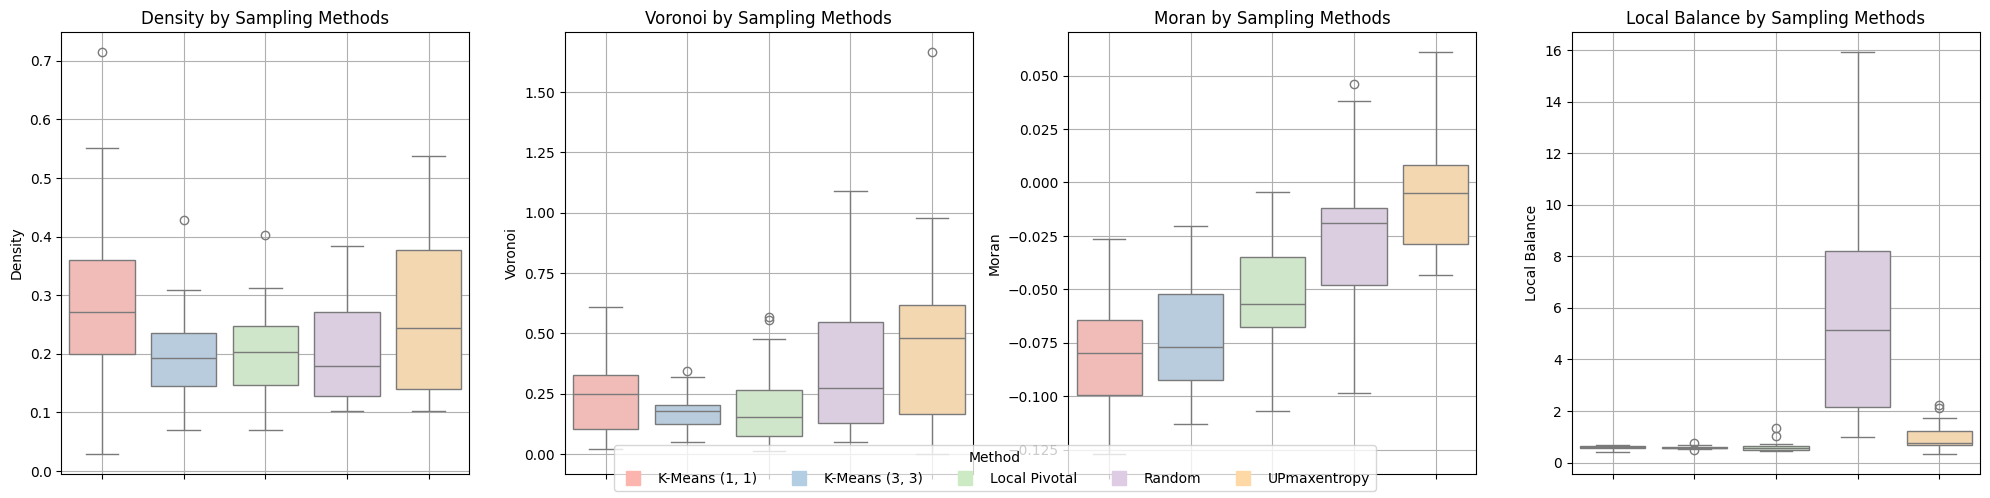

In [ ]:
number_of_items = len(columns[1:])
n_cols = 4  # how many plots per row
n_rows = (number_of_items + n_cols - 1) // n_cols  # compute needed rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

axes = axes.flatten()

for idx, column in enumerate(columns[1:]):
    sns.boxplot(x="Method", y=column, data=remove_outliers(df, column, IQR_coef=3, groupby_col="Method"), hue="Method", palette=method_palette, ax=axes[idx])
    axes[idx].set_title(f'{column} by Sampling Methods')
    axes[idx].set_xlabel("")
    axes[idx].set_xticklabels([])
    axes[idx].grid(True)

handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10, label=method) for method, color in method_palette.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(methods), fontsize=10, title="Method")

fig.tight_layout()
plt.show()